In [1]:
import numpy as np 
import pyxu.experimental.xray as pxr
import pyxu.opt.stop as pxst
import matplotlib.pyplot as plt
import xrt_splines
import pat_xrt
import matplotlib
import cupy as cp
from cupyx.profiler import benchmark
from skimage.transform import iradon
from scipy.signal import convolve2d as spconv
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from scipy.signal import fftconvolve
from skimage.transform import resize
import xdesign as xd

cp.cuda.Device(0).use()

<CUDA Device 0>

In [2]:
def set_operators_parallel_beam(N_side, N_angle, N_offset, pitch_op, arg_shape):
    # Let's build the necessary components to instantiate the operator . ========================
    angles = np.linspace(0, np.pi, N_angle, endpoint=False)

    n = np.stack([np.cos(angles), np.sin(angles)], axis=1)
    pitch = 1.
    t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
    t_max    = pitch * (N_side-1) / 2 * 1.  # 10% over ball radius
    t_offset = np.linspace(-t_max, t_max, N_offset, endpoint=True)

    n_spec  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset, 2))  # (N_angle, N_offset, 2)
    t_spec  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset, 1)  # (N_angle, N_offset, 2)
    t_spec += pitch * N_side / 2  # Move anchor point to the center of volume.
    extra   = np.ones((1,N_angle*N_offset,1))
    origin  = (0., 0.)
    pitch   = (1.,1.)

    t_spec  = cp.array(t_spec)
    n_spec  = cp.array(n_spec)

    op_splines_1 = xrt_splines.RayXRT(
        deg=1,
        arg_shape=arg_shape,
        t_spec=t_spec.reshape(-1,2), 
        n_spec=n_spec.reshape(-1,2),
        origin=origin,
        pitch=pitch_op,
    )
    op_splines_2 = xrt_splines.RayXRT(
        deg=2,
        arg_shape=arg_shape,
        t_spec=t_spec.reshape(-1,2), 
        n_spec=n_spec.reshape(-1,2),
        origin=origin,
        pitch=pitch_op,
    )
    op_pixels = pxr.XRayTransform.init(
        arg_shape=arg_shape,
        t_spec=t_spec.reshape(-1,2), 
        n_spec=n_spec.reshape(-1,2),
        origin=origin,
        pitch=pitch_op,
    )

    return op_pixels, op_splines_1, op_splines_2



def create_phantom(N_side, type):
    if type=='gaussian':
        xx = np.linspace(-N_side//2,N_side//2, num=N_side)
        yy = xx
        X, Y = np.meshgrid(xx,yy)
        r = 700
        mask = np.sqrt(X**2 + Y**2) < r
        phantom = np.exp(-((X-517)**2 + (Y+429)**2)/400000) + 0.5*np.exp(-((X+673)**2 + (Y-687)**2)/400000)

    if type=='sharp':
        seed = 0
        # Generate phantom with xdesign
        np.random.seed(seed)
        p1 = xd.Foam(size_range=[0.1, 0.01], gap=0.025, porosity=0.5)
        phantom = xd.discrete_phantom(p1, N_side-400-370) * 10
        phantom = np.pad(phantom, ((370, 0), (370, 0)))
        phantom = np.abs(np.pad(phantom, 200))
    return cp.array(phantom)

(5000, 5000)


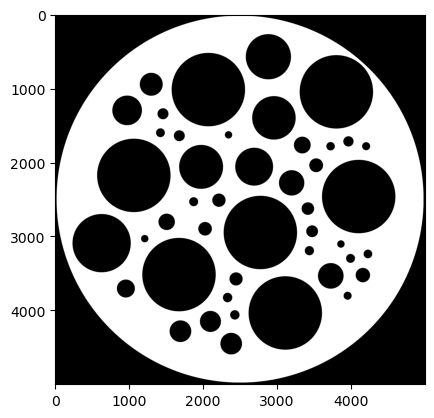

In [4]:
N_side = 3000 #5000

#phantom = create_phantom(N_side, "sharp")

# load phantom
phantom = cp.array(np.load('phantom.npy'))

arg_shape = phantom.shape
print(arg_shape)
plt.figure()
plt.imshow(phantom.get(), cmap='gray')
plt.show()


/home/haouchat/cryo-ct/xrt_splines.py:210: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)
/home/haouchat/miniconda3/envs/pyxu/lib/python3.11/site-packages/pyxu/experimental/xray/_rt.py:208: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)
/home/haouchat/miniconda3/envs/pyxu/lib/python3.11/site-packages/pyxu/experimental/xray/_rt.py:208: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)
INFO:/tmp/pyxu_o0xbe631:[2025-03-09 18:22:55.537607] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_o0xbe631:[2025-03-09 18:22:55.768447] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_o0xbe631:[2025-03-09 18:22:55.780284] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_o0xbe631:[2025-03-09 18:22:55.791358] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_o0xbe631:[2025

sample normal
norm diff splines :  3705.5825134889924
norm diff pixels  :  3657.582499477512


Oversampled
norm diff splines :  82256.90823085658
norm diff pixels  :  115494.39706061005
14269.933336666918
14207.533873185543


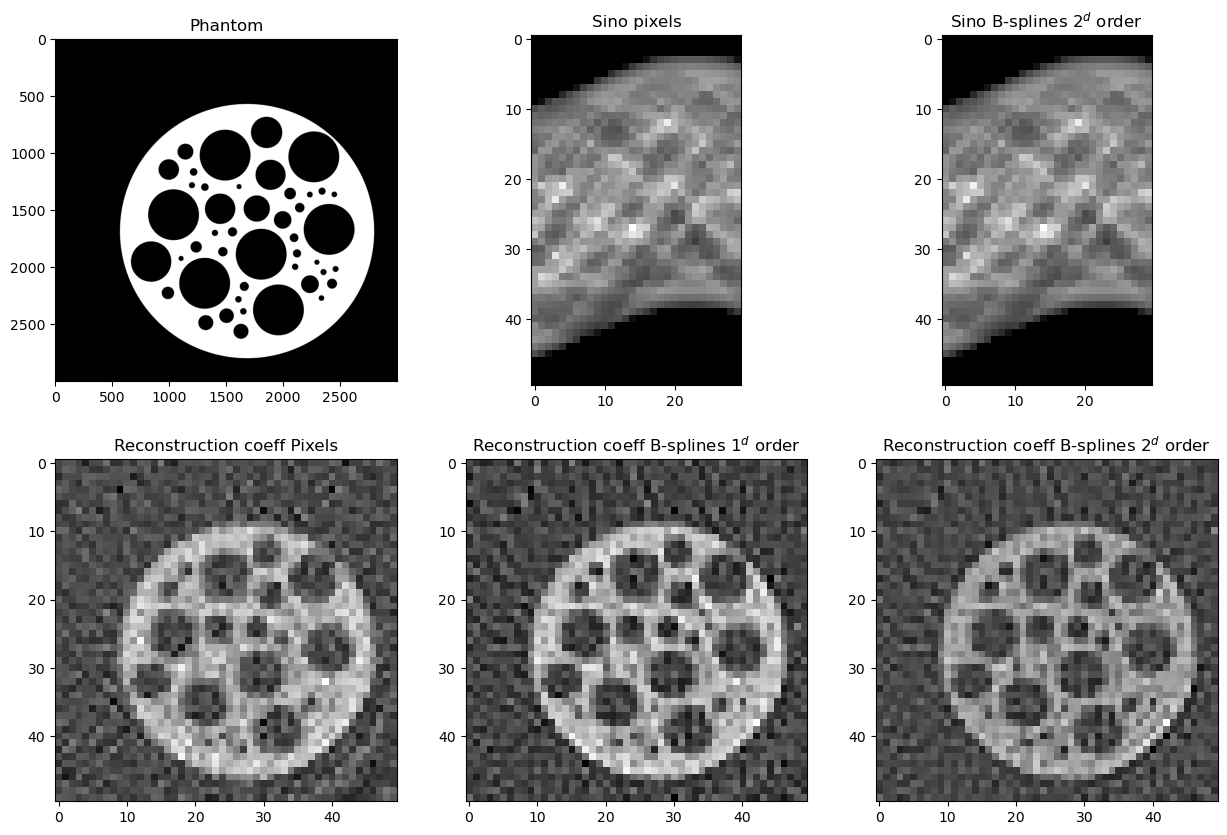

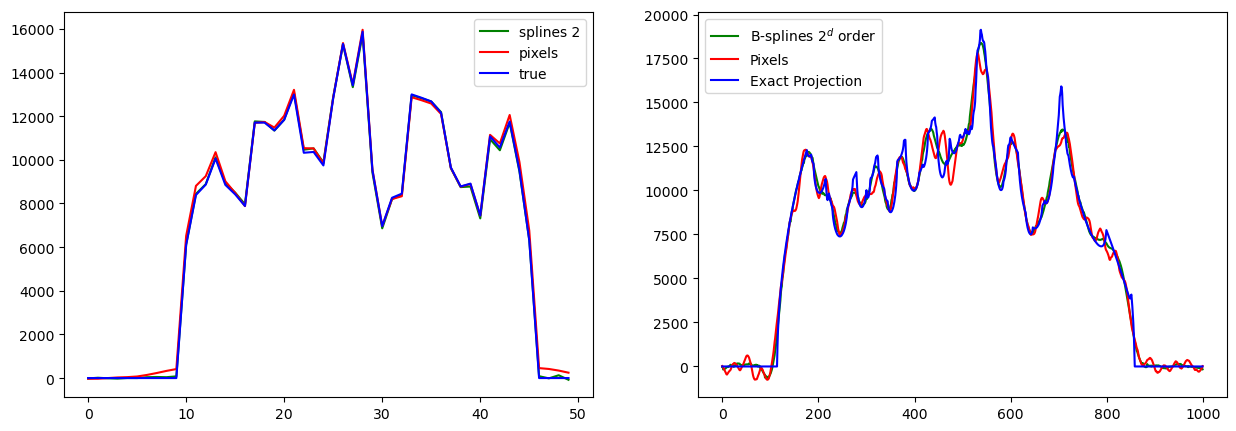

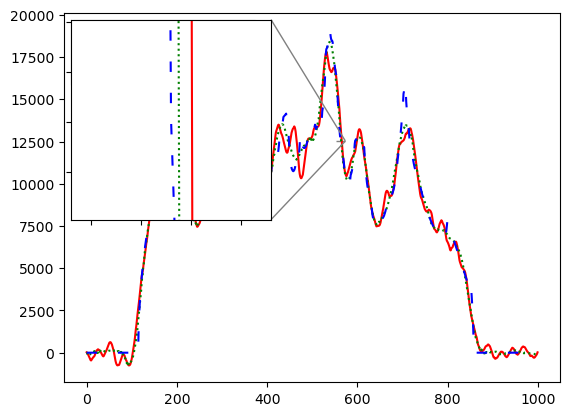

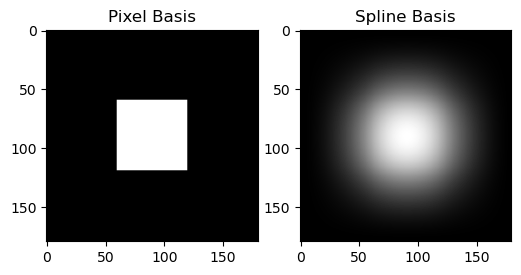

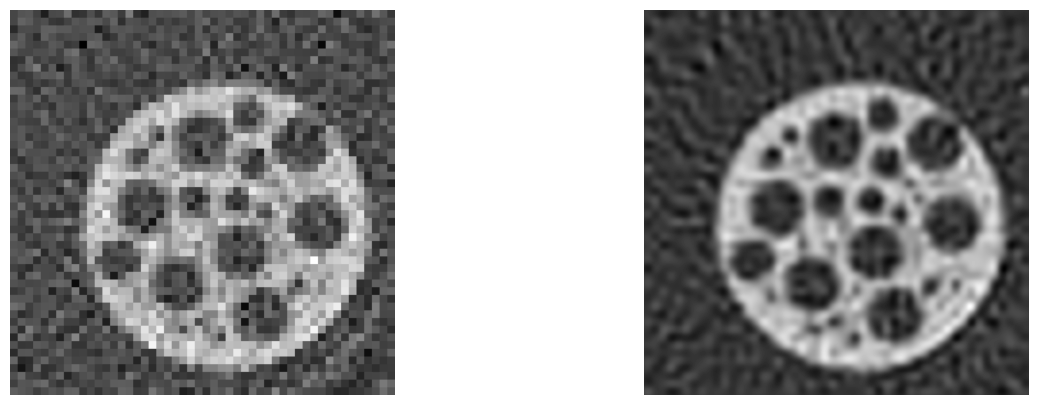

In [4]:

pitch_op = (1.,1.) 
N_angle  = 30
N_offset = 50
op_pixels, op_splines_1, op_splines_2 = set_operators_parallel_beam(N_side, N_angle, N_offset, pitch_op, arg_shape)

N_offset_true = 1000
op_true, _, _ = set_operators_parallel_beam(N_side, N_angle, N_offset_true, pitch_op, arg_shape)

fwd_splines_1 = op_splines_1.apply(phantom.reshape(-1))
fwd_splines_2 = op_splines_2.apply(phantom.reshape(-1))
fwd_pixels = op_pixels.apply(phantom.reshape(-1))

y_data = fwd_pixels

fwd_splines_1 = fwd_splines_1.reshape((N_angle, N_offset)).get() 
fwd_splines_2 = fwd_splines_2.reshape((N_angle, N_offset)).get()
fwd_pixels = fwd_pixels.reshape((N_angle, N_offset)).get() 
sinogram_astra = fwd_pixels

stop_crit = pxst.MaxIter(30)

oversampling = 50
pitch_op = (phantom.shape[0]/oversampling, phantom.shape[0]/oversampling)
arg_shape = (oversampling, oversampling)
op_pixels, op_splines_1, op_splines_2 = set_operators_parallel_beam(N_side, N_angle, N_offset, pitch_op, arg_shape)

recon_pixels = op_pixels.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
recon_box_1 = op_splines_1.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
recon_box_2 = op_splines_2.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

#plt.figure('Phantom')
#plt.imshow(phantom, cmap='gray')
axes[0, 0].imshow(phantom.get(), cmap='gray')
axes[0, 0].set_title('Phantom')
#plt.figure('sino')
#plt.imshow(fwd_splines_1.reshape((N_angle, N_offset)).T, cmap='gray')
axes[0, 1].imshow(fwd_pixels.T, cmap='gray')
axes[0, 1].set_title('Sino pixels')

axes[0, 2].imshow(fwd_splines_2.T, cmap='gray')
axes[0, 2].set_title('Sino B-splines $2^d$ order')

#plt.figure('recon pix')
#plt.imshow(recon_pixels.get(), cmap='gray')
axes[1, 0].imshow(recon_pixels.get(), cmap='gray')
axes[1, 0].set_title('Reconstruction coeff Pixels')

#plt.figure('recon splines 1')
#plt.imshow(recon_box_1.get(), cmap='gray')
axes[1, 1].imshow(recon_box_1.get(), cmap='gray')
axes[1, 1].set_title('Reconstruction coeff B-splines $1^d$ order')

#plt.figure('recon splines 2')
plt.imshow(recon_box_2.get(), cmap='gray')
axes[1, 2].imshow(recon_box_2.get(), cmap='gray')
axes[1, 2].set_title('Reconstruction coeff B-splines $2^d$ order')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
#plt.figure('fwd - recon')
fwd = op_splines_1.apply(recon_box_1.reshape(-1)).get()
fwd_splines = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_splines[0], c='green', label='splines 2')
axes[0].plot(fwd_splines[0], c='green', label='splines 2')
fwd = op_pixels.apply(recon_pixels.reshape(-1)).get()
fwd_pixels = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_pixels[0], c='red', label='pixels')
axes[0].plot(fwd_pixels[0], c='red', label='pixels')
true_proj = y_data.get().reshape((N_angle, N_offset))
#plt.plot(true_proj[0], c='blue', label='true')
axes[0].plot(true_proj[0], c='blue', label='true')
print('sample normal')
norm1 = np.linalg.norm(true_proj - fwd_splines)
print('norm diff splines : ', norm1)
norm2 = np.linalg.norm(true_proj - fwd_pixels)
print('norm diff pixels  : ', norm2)
axes[0].legend()

N_offset = 1000
op_pixels, op_splines_1, op_splines_2 = set_operators_parallel_beam(N_side, N_angle, N_offset_true, pitch_op, arg_shape)

#plt.figure('fwd - recon (many offsets)')
fwd = op_splines_2.apply(recon_box_2.reshape(-1)).get()
fwd_splines = fwd.reshape((N_angle, N_offset_true))
#plt.plot(fwd_splines[9], c='green', label='B-splines $2^d$ order')
axes[1].plot(fwd_splines[9], c='green', label='B-splines $2^d$ order')
fwd = op_pixels.apply(recon_pixels.reshape(-1)).get()
fwd_pixels = fwd.reshape((N_angle, N_offset_true))
#plt.plot(fwd_pixels[9], c='red', label='Pixels')
axes[1].plot(fwd_pixels[9], c='red', label='Pixels')
true_proj = op_true.apply(phantom.reshape(-1)).get()
true_proj = true_proj.reshape((N_angle, N_offset_true))
#plt.plot(true_proj[9], c='blue', label='Exact Projection')
axes[1].plot(true_proj[9], c='blue', label='Exact Projection')
#plt.legend()
axes[1].legend()

fig, ax = plt.subplots()
axins = inset_axes(ax, 2,2 , loc=2)

ax.plot(fwd_pixels[9], label='Pixels', c='red')
axins.plot(fwd_pixels[9], label='Pixels', c='red')

#dotted lines
ax.plot(fwd_splines[9], label='Quadratic B-splines', c='green', linestyle = 'dotted')
axins.plot(fwd_splines[9], label='Quadratic B-splines', c='green', linestyle = 'dotted')

#dashed lines
ax.plot(true_proj[9], label='Exact', c='blue', linestyle='--', dashes=(5, 10))
axins.plot(true_proj[9], label='Exact', c='blue', linestyle='--', dashes=(5, 10))

x_baseline = 563
y_true = true_proj[9][x_baseline]
x1, x2, y1, y2 = x_baseline-10, x_baseline+10, y_true-10, y_true+10
#505+10, 505+20, 1332-10, 1332+10 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits

plt.xticks(visible=False)
plt.yticks(visible=False)

mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5")
ax.legend()
plt.savefig('inset.eps', format='eps')

print('Oversampled')
norm1 = np.linalg.norm(true_proj - fwd_splines)
print('norm diff splines : ', norm1)
norm2 = np.linalg.norm(true_proj - fwd_pixels)
print('norm diff pixels  : ', norm2)

NN = phantom.shape[0]//oversampling
mini_im = np.zeros((3*NN, 3*NN))
mini_im_pix = mini_im
mini_im_spline = mini_im

rec_pix = recon_pixels.get()
rec_spline = recon_box_2.get()

mini_im_pix[NN:2*NN, NN:2*NN] = 1
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

ax[0].imshow(mini_im_pix, cmap='gray')
ax[0].set_title('Pixel Basis')

mini_im_spline = spconv(mini_im_pix, mini_im_pix[NN:2*NN, NN:2*NN], mode='same')
mini_im_spline = spconv(mini_im_spline, mini_im_pix[NN:2*NN, NN:2*NN], mode='same')

ax[1].imshow(mini_im_spline, cmap='gray')
ax[1].set_title('Spline Basis')

full_im_pix = np.zeros((phantom.shape[0] + 2*NN, phantom.shape[0] + 2*NN))
for i in range(oversampling):
    for j in range(oversampling):
        i_min, i_max, j_min, j_max = NN*i, NN*i+3*NN, NN*j, NN*j+3*NN
        full_im_pix[i_min : i_max, j_min:j_max] += mini_im_pix * rec_pix[i,j]

full_im_spline = np.zeros((phantom.shape[0] + 2*NN, phantom.shape[0] + 2*NN))
for i in range(oversampling):
    for j in range(oversampling):
        i_min, i_max, j_min, j_max = NN*i, NN*i+3*NN, NN*j, NN*j+3*NN
        full_im_spline[i_min : i_max, j_min:j_max] += mini_im_spline * rec_spline[i,j]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(full_im_pix[NN:-NN, NN:-NN], cmap='gray')
ax[1].imshow(full_im_spline[NN:-NN, NN:-NN], cmap='gray')
for a in ax:
    a.axis('off')
plt.savefig('upsampled.eps', format='eps')

print(np.linalg.norm(full_im_pix[NN:-NN, NN:-NN]/np.max(full_im_pix[NN:-NN, NN:-NN]) - phantom.get()))
print(np.linalg.norm(full_im_spline[NN:-NN, NN:-NN]/np.max(full_im_spline[NN:-NN, NN:-NN]) - phantom.get()))

plt.show()

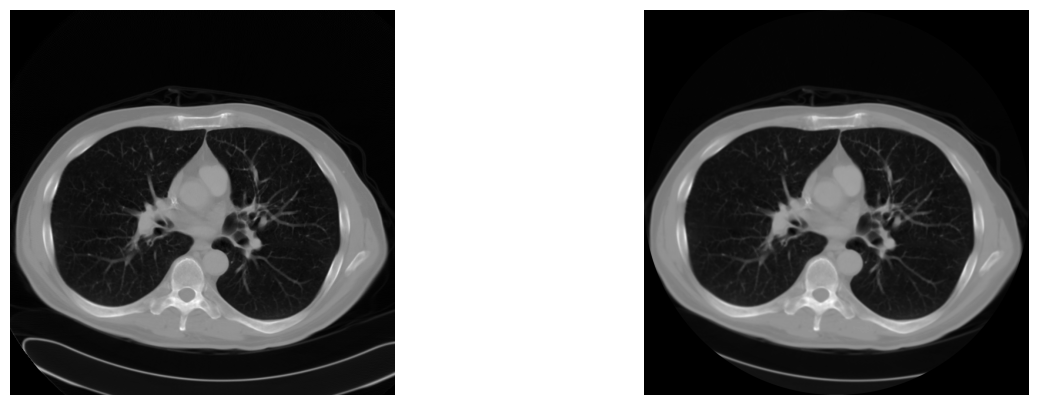

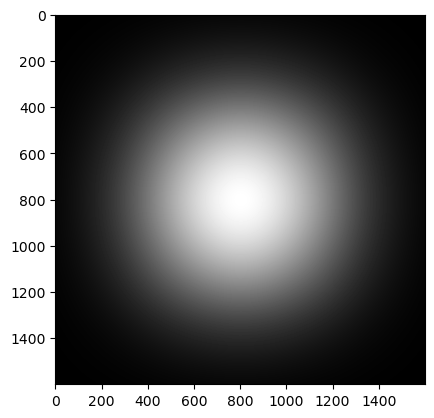

In [5]:
import astra 

N_basis = 1600
XX, YY = np.meshgrid(np.linspace(-1.5, 1.5, N_basis), np.linspace(-1.5, 1.5, N_basis))
YY = np.flip(YY, axis=0)
pixelsize = 3/N_basis

spline_basis1 = np.zeros((N_basis, N_basis))
spline_basis1 = np.where(np.abs(YY)<pixelsize, 1, 0)
spline_basis1 = np.where(XX<1/2, spline_basis1, 0)
spline_basis1 = np.where(XX>-1/2, spline_basis1, 0)

spline_basis2 = np.zeros((N_basis, N_basis))
spline_basis2 = np.where(np.abs(XX)<pixelsize, 1, 0)
spline_basis2 = np.where(YY<1/2, spline_basis2, 0)
spline_basis2 = np.where(YY>-1/2, spline_basis2, 0)

spline_basis3 = np.zeros((N_basis, N_basis))
spline_basis3 = np.where(np.abs(XX-YY)<np.sqrt(2)*pixelsize, 1, 0)
spline_basis3 = np.where(XX < 1/2, spline_basis3, 0)
spline_basis3 = np.where((XX) > -1/2, spline_basis3, 0)

spline_basis4 = np.zeros((N_basis, N_basis))
spline_basis4 = np.where(np.abs(XX+YY)<np.sqrt(2)*pixelsize, 1, 0)
spline_basis4 = np.where(XX < 1/2, spline_basis4, 0)
spline_basis4 = np.where((XX) > -1/2, spline_basis4, 0)

spline_basis_0 = fftconvolve(spline_basis1, spline_basis2, mode='same')
spline_basis_1 = fftconvolve(spline_basis_0, spline_basis3, mode='same')
spline_basis_2 = fftconvolve(spline_basis_1, spline_basis4, mode='same')
final_size = N_side
#spline_basis_1 = np.flip(spline_basis_1, axis=0)

#random_phantom = np.random.randn(50, 50)
from skimage import io

image_path = "true.tiff"
# Open the TIFF image
random_phantom = io.imread(image_path)[12:512, :500]
oversampling = 500
factor = final_size//oversampling

spline_basis_3 = fftconvolve(spline_basis_0, spline_basis_0, mode='same')
spline_basis_3 = fftconvolve(spline_basis_3, spline_basis_0, mode='same')
spline_basis_3 = fftconvolve(spline_basis_3, spline_basis_0, mode='same')

spline_basis = resize(spline_basis_3, (3*factor, 3*factor), anti_aliasing=False)
full_im_spline = np.zeros((final_size, final_size))
for i in range(oversampling):
    for j in range(oversampling):
        full_im_spline[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = random_phantom[i, j]

phantom = fftconvolve(full_im_spline, spline_basis, mode='same')
#circle mask with zeros outside
XX, YY = np.meshgrid(np.linspace(-1, 1, final_size), np.linspace(-1, 1, final_size))
mask = np.sqrt(XX**2 + YY**2) < 1
phantom = (phantom - np.min(phantom))/(np.max(phantom) - np.min(phantom))
phantom = phantom*mask
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(random_phantom, cmap='gray')
ax[1].imshow(phantom, cmap='gray')
for a in ax:
    a.axis('off')
plt.show()
phantom = cp.array(phantom)/np.max(phantom)
plt.figure()
plt.imshow(spline_basis_3, cmap='gray')
plt.show()

#phantom = create_phantom(N_side, "gaussian")
phantom /= cp.max(phantom)

def run_xp(N_angle, N_offset, oversampling, phantom):
    
    arg_shape = phantom.shape

    pitch_op = (1.,1.) 
    op_pixels, op_splines_1, op_splines_2 = set_operators_parallel_beam(N_side, N_angle, N_offset, pitch_op, arg_shape)

    angles = np.linspace(0, np.pi, N_angle, endpoint=False)
    vol_geom = astra.create_vol_geom(phantom.shape[0], phantom.shape[1])
    det_spacing = N_side/N_offset
    proj_geom = astra.create_proj_geom('parallel', det_spacing, N_offset, angles)
    proj_id = astra.create_projector('line', proj_geom, vol_geom)
    sinogram_id, y_data_astra = astra.create_sino(np.array(phantom.get()), proj_id)
    y_data = cp.array(y_data_astra).reshape(-1) #+ 1*cp.random.randn(N_angle*N_offset)
    
    #y_data_astra = op_splines_2.apply(phantom.reshape(-1)).reshape((N_angle, N_offset)).get()

    ####### rec astra ########
    proj_geom = astra.create_proj_geom('parallel', 0.5, N_offset, angles)
    vol_geom  = astra.create_vol_geom(oversampling,oversampling)

    proj_id = astra.create_projector('line', proj_geom, vol_geom)
    sino_id   = astra.data2d.create('-sino', proj_geom, y_data_astra)
    rec_id    = astra.data2d.create('-vol', vol_geom)

    cfg       = astra.astra_dict('CGLS')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId']      = sino_id
    cfg['ProjectorId']          = proj_id

    alg_id    = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id, 50)
    rec_astra              = astra.data2d.get(rec_id)
    print(rec_astra.shape)
    ############################


    stop_crit = pxst.MaxIter(50)
    
    pitch_op = (phantom.shape[0]/oversampling, phantom.shape[0]/oversampling)
    arg_shape = (oversampling, oversampling)
    op_pixels, op_splines_1, op_splines_2 = set_operators_parallel_beam(N_side, N_angle, N_offset, pitch_op, arg_shape)

    recon_pixels = op_pixels.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
    recon_box_1 = op_splines_1.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
    recon_box_2 = op_splines_2.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))

    factor = final_size//oversampling


    rec_pix = recon_pixels.get()
    spline_basis = resize(spline_basis_0, (3*factor, 3*factor), mode='reflect', anti_aliasing=False)
    full_im_pix = np.zeros((final_size, final_size))

    for i in range(oversampling):
        for j in range(oversampling):
            full_im_pix[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = rec_pix[i, j]

    full_im_pix = fftconvolve(full_im_pix, spline_basis, mode='same')

    #for astra, use pixels also
    full_im_astra = np.zeros((final_size, final_size))
    for i in range(oversampling):
        for j in range(oversampling):
            full_im_astra[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = rec_astra[i, j]

    full_im_astra = fftconvolve(full_im_astra, spline_basis, mode='same')

    rec_spline = recon_box_1.get()
    spline_basis = resize(spline_basis_1, (3*factor, 3*factor), mode='reflect', anti_aliasing=False)
    full_im_spline = np.zeros((final_size, final_size))
    for i in range(oversampling):
        for j in range(oversampling):
            full_im_spline[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = rec_spline[i, j]

    full_im_spline1 = fftconvolve(full_im_spline, spline_basis, mode='same')

    rec_spline = recon_box_2.get()
    spline_basis = resize(spline_basis_2, (3*factor, 3*factor), mode='reflect', anti_aliasing=False)
    full_im_spline = np.zeros((final_size, final_size))
    for i in range(oversampling):
        for j in range(oversampling):
            full_im_spline[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = rec_spline[i, j]

    full_im_spline2 = fftconvolve(full_im_spline, spline_basis, mode='same')

    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    ax[0].imshow(full_im_pix, cmap='gray')
    ax[1].imshow(full_im_spline1, cmap='gray')
    ax[2].imshow(full_im_spline2, cmap='gray')
    ax[3].imshow(full_im_astra, cmap='gray')
    
    for a in ax:
        a.axis('off')
    #plt.savefig('upsampled.eps', format='eps')

    loss1 = psnr(phantom.get()/np.max(phantom.get()), full_im_pix/np.max(full_im_pix))
    loss2 = psnr(phantom.get()/np.max(phantom.get()), full_im_spline1/np.max(full_im_spline1))
    loss3 = psnr(phantom.get()/np.max(phantom.get()), full_im_spline2/np.max(full_im_spline2))
    loss4 = psnr(phantom.get()/np.max(phantom.get()), full_im_astra/np.max(full_im_astra))

    ssim1 = ssim(phantom.get()/np.max(phantom.get()), full_im_pix/np.max(full_im_pix), data_range=2)
    ssim2 = ssim(phantom.get()/np.max(phantom.get()), full_im_spline1/np.max(full_im_spline1), data_range=2)
    ssim3 = ssim(phantom.get()/np.max(phantom.get()), full_im_spline2/np.max(full_im_spline2), data_range=2)
    ssim4 = ssim(phantom.get()/np.max(phantom.get()), full_im_astra/np.max(full_im_astra), data_range=2)
    
    plt.show()

    return loss1, loss2, loss3, loss4, full_im_pix, full_im_spline1, full_im_spline2, full_im_astra, ssim1, ssim2, ssim3, ssim4


Oversampling :  20
(20, 20)


/home/haouchat/miniconda3/envs/pyxu/lib/python3.11/site-packages/pyxu/experimental/xray/_rt.py:208: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)
INFO:/tmp/pyxu_jg55swl6:[2025-03-10 00:11:01.667431] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_jg55swl6:[2025-03-10 00:11:01.869128] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_jg55swl6:[2025-03-10 00:11:01.880089] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_jg55swl6:[2025-03-10 00:11:01.890761] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_jg55swl6:[2025-03-10 00:11:01.901416] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_jg55swl6:[2025-03-10 00:11:01.912233] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_jg55swl6:[2025-03-10 00:11:01.923039] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_jg55swl6:[2025-03-10 00:11:01.933538] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_jg55swl6:[2025-03-10 00:11:01

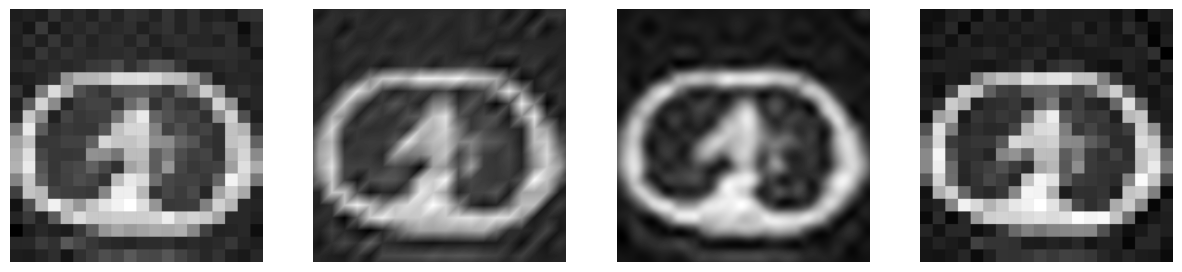

Losses :  15.58634709031554 18.822956492044856 17.369475080360417 15.668795121371213
SSIM :  0.6236956745691656 0.6713695238717697 0.6802081859609166 0.6194164442324186
Oversampling :  40


INFO:/tmp/pyxu_3_m_ob5m:[2025-03-10 00:11:17.529114] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_3_m_ob5m:[2025-03-10 00:11:17.552444] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_3_m_ob5m:[2025-03-10 00:11:17.563373] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_3_m_ob5m:[2025-03-10 00:11:17.574064] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_3_m_ob5m:[2025-03-10 00:11:17.585090] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_3_m_ob5m:[2025-03-10 00:11:17.596163] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_3_m_ob5m:[2025-03-10 00:11:17.607128] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_3_m_ob5m:[2025-03-10 00:11:17.617915] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_3_m_ob5m:[2025-03-10 00:11:17.628591] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_3_m_ob5m:[2025-03-10 00:11:17.639179] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_3_m_ob5m:[2025-03-10 00:11:17.649859] Iteration 10
	iteration: 1

(40, 40)


INFO:/tmp/pyxu_3_m_ob5m:[2025-03-10 00:11:17.715898] Iteration 16
	iteration: 16
	N_iter: 17.0
INFO:/tmp/pyxu_3_m_ob5m:[2025-03-10 00:11:17.726637] Iteration 17
	iteration: 17
	N_iter: 18.0
INFO:/tmp/pyxu_3_m_ob5m:[2025-03-10 00:11:17.737204] Iteration 18
	iteration: 18
	N_iter: 19.0
INFO:/tmp/pyxu_3_m_ob5m:[2025-03-10 00:11:17.747908] Iteration 19
	iteration: 19
	N_iter: 20.0
INFO:/tmp/pyxu_3_m_ob5m:[2025-03-10 00:11:17.759003] Iteration 20
	iteration: 20
	N_iter: 21.0
INFO:/tmp/pyxu_3_m_ob5m:[2025-03-10 00:11:17.770037] Iteration 21
	iteration: 21
	N_iter: 22.0
INFO:/tmp/pyxu_3_m_ob5m:[2025-03-10 00:11:17.780923] Iteration 22
	iteration: 22
	N_iter: 23.0
INFO:/tmp/pyxu_3_m_ob5m:[2025-03-10 00:11:17.791652] Iteration 23
	iteration: 23
	N_iter: 24.0
INFO:/tmp/pyxu_3_m_ob5m:[2025-03-10 00:11:17.802449] Iteration 24
	iteration: 24
	N_iter: 25.0
INFO:/tmp/pyxu_3_m_ob5m:[2025-03-10 00:11:17.813103] Iteration 25
	iteration: 25
	N_iter: 26.0
INFO:/tmp/pyxu_3_m_ob5m:[2025-03-10 00:11:17.82385

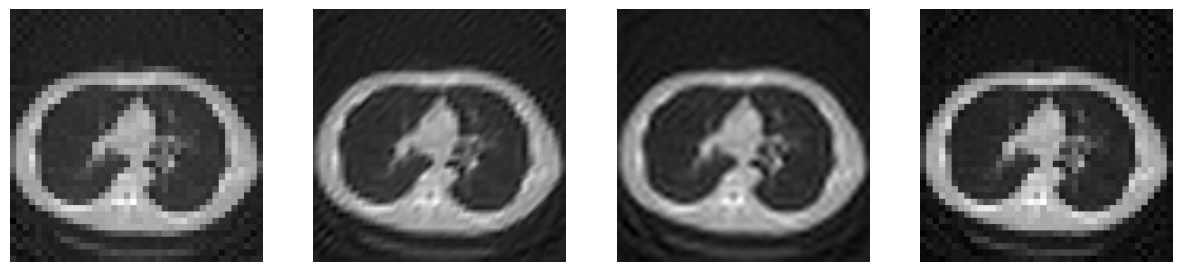

Losses :  20.898951102513568 23.468708697165937 23.420874597040957 20.78517828334551
SSIM :  0.7695032123299336 0.7997696230604302 0.8112882694281548 0.7676685069596344
Oversampling :  50


INFO:/tmp/pyxu_olru3i7q:[2025-03-10 00:11:33.068027] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_olru3i7q:[2025-03-10 00:11:33.088661] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_olru3i7q:[2025-03-10 00:11:33.100514] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_olru3i7q:[2025-03-10 00:11:33.112750] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_olru3i7q:[2025-03-10 00:11:33.125549] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_olru3i7q:[2025-03-10 00:11:33.137701] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_olru3i7q:[2025-03-10 00:11:33.149212] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_olru3i7q:[2025-03-10 00:11:33.160691] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_olru3i7q:[2025-03-10 00:11:33.172381] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_olru3i7q:[2025-03-10 00:11:33.184006] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_olru3i7q:[2025-03-10 00:11:33.195790] Iteration 10
	iteration: 1

(50, 50)


INFO:/tmp/pyxu_olru3i7q:[2025-03-10 00:11:33.254447] Iteration 15
	iteration: 15
	N_iter: 16.0
INFO:/tmp/pyxu_olru3i7q:[2025-03-10 00:11:33.265924] Iteration 16
	iteration: 16
	N_iter: 17.0
INFO:/tmp/pyxu_olru3i7q:[2025-03-10 00:11:33.277854] Iteration 17
	iteration: 17
	N_iter: 18.0
INFO:/tmp/pyxu_olru3i7q:[2025-03-10 00:11:33.289947] Iteration 18
	iteration: 18
	N_iter: 19.0
INFO:/tmp/pyxu_olru3i7q:[2025-03-10 00:11:33.301759] Iteration 19
	iteration: 19
	N_iter: 20.0
INFO:/tmp/pyxu_olru3i7q:[2025-03-10 00:11:33.313735] Iteration 20
	iteration: 20
	N_iter: 21.0
INFO:/tmp/pyxu_olru3i7q:[2025-03-10 00:11:33.325242] Iteration 21
	iteration: 21
	N_iter: 22.0
INFO:/tmp/pyxu_olru3i7q:[2025-03-10 00:11:33.336833] Iteration 22
	iteration: 22
	N_iter: 23.0
INFO:/tmp/pyxu_olru3i7q:[2025-03-10 00:11:33.348374] Iteration 23
	iteration: 23
	N_iter: 24.0
INFO:/tmp/pyxu_olru3i7q:[2025-03-10 00:11:33.360023] Iteration 24
	iteration: 24
	N_iter: 25.0
INFO:/tmp/pyxu_olru3i7q:[2025-03-10 00:11:33.37186

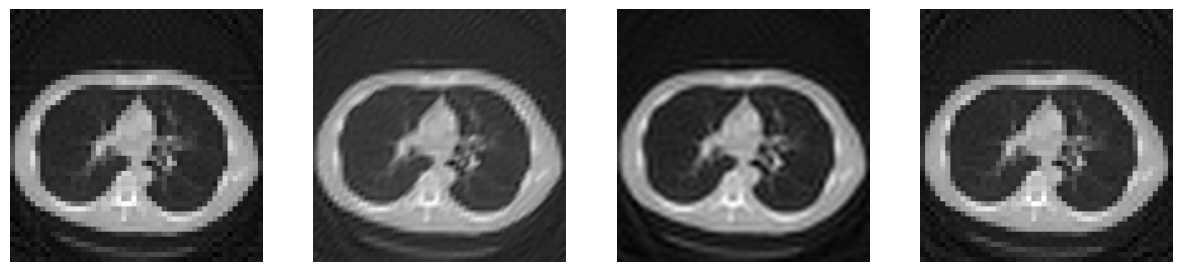

Losses :  21.40396476766742 24.216775673081543 24.06547262659886 22.05920106595776
SSIM :  0.7884448054204003 0.833151455625114 0.8479503319584822 0.7827040356497856
Oversampling :  75


INFO:/tmp/pyxu_o5bzm6jr:[2025-03-10 00:11:50.017707] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_o5bzm6jr:[2025-03-10 00:11:50.037619] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_o5bzm6jr:[2025-03-10 00:11:50.049172] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_o5bzm6jr:[2025-03-10 00:11:50.060764] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_o5bzm6jr:[2025-03-10 00:11:50.072625] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_o5bzm6jr:[2025-03-10 00:11:50.084487] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_o5bzm6jr:[2025-03-10 00:11:50.096337] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_o5bzm6jr:[2025-03-10 00:11:50.108213] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_o5bzm6jr:[2025-03-10 00:11:50.119954] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_o5bzm6jr:[2025-03-10 00:11:50.131633] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_o5bzm6jr:[2025-03-10 00:11:50.143254] Iteration 10
	iteration: 1

(75, 75)


INFO:/tmp/pyxu_o5bzm6jr:[2025-03-10 00:11:50.200733] Iteration 15
	iteration: 15
	N_iter: 16.0
INFO:/tmp/pyxu_o5bzm6jr:[2025-03-10 00:11:50.212250] Iteration 16
	iteration: 16
	N_iter: 17.0
INFO:/tmp/pyxu_o5bzm6jr:[2025-03-10 00:11:50.223995] Iteration 17
	iteration: 17
	N_iter: 18.0
INFO:/tmp/pyxu_o5bzm6jr:[2025-03-10 00:11:50.235715] Iteration 18
	iteration: 18
	N_iter: 19.0
INFO:/tmp/pyxu_o5bzm6jr:[2025-03-10 00:11:50.247521] Iteration 19
	iteration: 19
	N_iter: 20.0
INFO:/tmp/pyxu_o5bzm6jr:[2025-03-10 00:11:50.259276] Iteration 20
	iteration: 20
	N_iter: 21.0
INFO:/tmp/pyxu_o5bzm6jr:[2025-03-10 00:11:50.271008] Iteration 21
	iteration: 21
	N_iter: 22.0
INFO:/tmp/pyxu_o5bzm6jr:[2025-03-10 00:11:50.282904] Iteration 22
	iteration: 22
	N_iter: 23.0
INFO:/tmp/pyxu_o5bzm6jr:[2025-03-10 00:11:50.294681] Iteration 23
	iteration: 23
	N_iter: 24.0
INFO:/tmp/pyxu_o5bzm6jr:[2025-03-10 00:11:50.306257] Iteration 24
	iteration: 24
	N_iter: 25.0
INFO:/tmp/pyxu_o5bzm6jr:[2025-03-10 00:11:50.31782

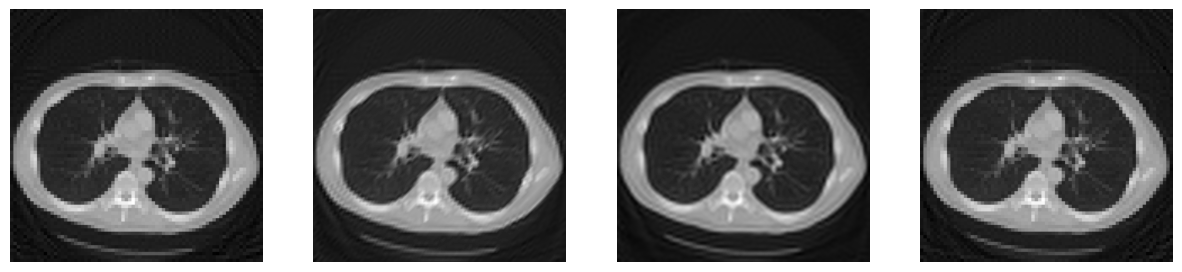

Losses :  24.007432992797053 26.753992828960328 27.423002834099318 24.751116733044217
SSIM :  0.8339286050458049 0.8857575511876573 0.9063438608242802 0.8338059273916234
Oversampling :  100


INFO:/tmp/pyxu_e0cetsq3:[2025-03-10 00:12:09.157304] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_e0cetsq3:[2025-03-10 00:12:09.176827] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_e0cetsq3:[2025-03-10 00:12:09.187932] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_e0cetsq3:[2025-03-10 00:12:09.199403] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_e0cetsq3:[2025-03-10 00:12:09.210854] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_e0cetsq3:[2025-03-10 00:12:09.222211] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_e0cetsq3:[2025-03-10 00:12:09.233596] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_e0cetsq3:[2025-03-10 00:12:09.244902] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_e0cetsq3:[2025-03-10 00:12:09.256087] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_e0cetsq3:[2025-03-10 00:12:09.266822] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_e0cetsq3:[2025-03-10 00:12:09.277899] Iteration 10
	iteration: 1

(100, 100)


INFO:/tmp/pyxu_e0cetsq3:[2025-03-10 00:12:09.346048] Iteration 16
	iteration: 16
	N_iter: 17.0
INFO:/tmp/pyxu_e0cetsq3:[2025-03-10 00:12:09.356967] Iteration 17
	iteration: 17
	N_iter: 18.0
INFO:/tmp/pyxu_e0cetsq3:[2025-03-10 00:12:09.367991] Iteration 18
	iteration: 18
	N_iter: 19.0
INFO:/tmp/pyxu_e0cetsq3:[2025-03-10 00:12:09.379261] Iteration 19
	iteration: 19
	N_iter: 20.0
INFO:/tmp/pyxu_e0cetsq3:[2025-03-10 00:12:09.390437] Iteration 20
	iteration: 20
	N_iter: 21.0
INFO:/tmp/pyxu_e0cetsq3:[2025-03-10 00:12:09.401918] Iteration 21
	iteration: 21
	N_iter: 22.0
INFO:/tmp/pyxu_e0cetsq3:[2025-03-10 00:12:09.413525] Iteration 22
	iteration: 22
	N_iter: 23.0
INFO:/tmp/pyxu_e0cetsq3:[2025-03-10 00:12:09.425131] Iteration 23
	iteration: 23
	N_iter: 24.0
INFO:/tmp/pyxu_e0cetsq3:[2025-03-10 00:12:09.436775] Iteration 24
	iteration: 24
	N_iter: 25.0
INFO:/tmp/pyxu_e0cetsq3:[2025-03-10 00:12:09.448393] Iteration 25
	iteration: 25
	N_iter: 26.0
INFO:/tmp/pyxu_e0cetsq3:[2025-03-10 00:12:09.46002

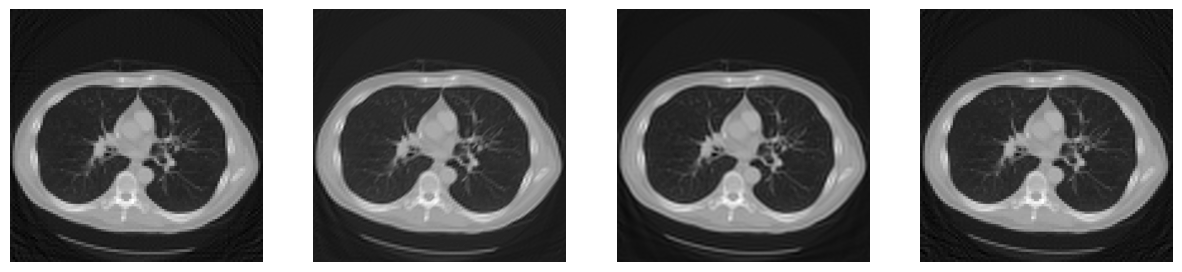

Losses :  25.745973820008814 28.97264875435869 29.27910520553004 26.430111860181242
SSIM :  0.8597544080954926 0.9238477703531695 0.9337038069378113 0.8616682796316472
Oversampling :  120


INFO:/tmp/pyxu_oldbe2h7:[2025-03-10 00:12:30.769800] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_oldbe2h7:[2025-03-10 00:12:30.788749] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_oldbe2h7:[2025-03-10 00:12:30.799963] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_oldbe2h7:[2025-03-10 00:12:30.811413] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_oldbe2h7:[2025-03-10 00:12:30.823248] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_oldbe2h7:[2025-03-10 00:12:30.834915] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_oldbe2h7:[2025-03-10 00:12:30.846587] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_oldbe2h7:[2025-03-10 00:12:30.858358] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_oldbe2h7:[2025-03-10 00:12:30.870127] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_oldbe2h7:[2025-03-10 00:12:30.881536] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_oldbe2h7:[2025-03-10 00:12:30.893146] Iteration 10
	iteration: 1

(120, 120)


INFO:/tmp/pyxu_oldbe2h7:[2025-03-10 00:12:30.951165] Iteration 15
	iteration: 15
	N_iter: 16.0
INFO:/tmp/pyxu_oldbe2h7:[2025-03-10 00:12:30.962302] Iteration 16
	iteration: 16
	N_iter: 17.0
INFO:/tmp/pyxu_oldbe2h7:[2025-03-10 00:12:30.974035] Iteration 17
	iteration: 17
	N_iter: 18.0
INFO:/tmp/pyxu_oldbe2h7:[2025-03-10 00:12:30.985810] Iteration 18
	iteration: 18
	N_iter: 19.0
INFO:/tmp/pyxu_oldbe2h7:[2025-03-10 00:12:30.997581] Iteration 19
	iteration: 19
	N_iter: 20.0
INFO:/tmp/pyxu_oldbe2h7:[2025-03-10 00:12:31.009432] Iteration 20
	iteration: 20
	N_iter: 21.0
INFO:/tmp/pyxu_oldbe2h7:[2025-03-10 00:12:31.021145] Iteration 21
	iteration: 21
	N_iter: 22.0
INFO:/tmp/pyxu_oldbe2h7:[2025-03-10 00:12:31.032912] Iteration 22
	iteration: 22
	N_iter: 23.0
INFO:/tmp/pyxu_oldbe2h7:[2025-03-10 00:12:31.044679] Iteration 23
	iteration: 23
	N_iter: 24.0
INFO:/tmp/pyxu_oldbe2h7:[2025-03-10 00:12:31.056235] Iteration 24
	iteration: 24
	N_iter: 25.0
INFO:/tmp/pyxu_oldbe2h7:[2025-03-10 00:12:31.06780

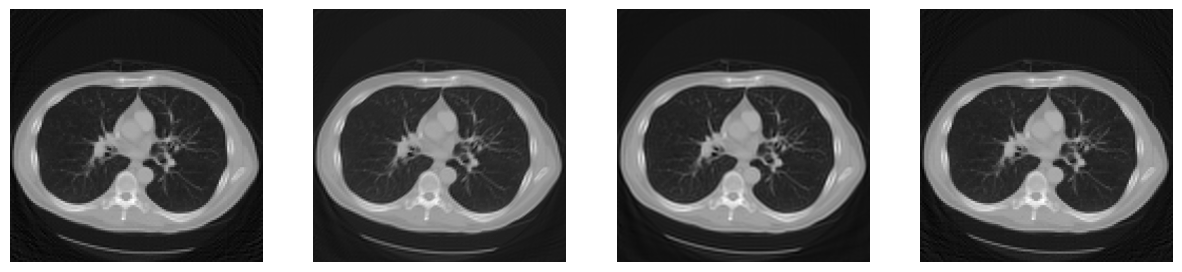

Losses :  27.041583959473734 30.8201159555265 30.836110526420537 27.63538814216856
SSIM :  0.8793224928622787 0.9401931294981186 0.9477628382779443 0.882693304204621
Oversampling :  150


INFO:/tmp/pyxu_hca3e26t:[2025-03-10 00:12:57.982167] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_hca3e26t:[2025-03-10 00:12:58.004469] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_hca3e26t:[2025-03-10 00:12:58.016033] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_hca3e26t:[2025-03-10 00:12:58.027672] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_hca3e26t:[2025-03-10 00:12:58.039222] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_hca3e26t:[2025-03-10 00:12:58.050919] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_hca3e26t:[2025-03-10 00:12:58.062587] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_hca3e26t:[2025-03-10 00:12:58.074106] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_hca3e26t:[2025-03-10 00:12:58.085833] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_hca3e26t:[2025-03-10 00:12:58.097457] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_hca3e26t:[2025-03-10 00:12:58.109349] Iteration 10
	iteration: 1

(150, 150)


INFO:/tmp/pyxu_hca3e26t:[2025-03-10 00:12:58.168054] Iteration 15
	iteration: 15
	N_iter: 16.0
INFO:/tmp/pyxu_hca3e26t:[2025-03-10 00:12:58.179617] Iteration 16
	iteration: 16
	N_iter: 17.0
INFO:/tmp/pyxu_hca3e26t:[2025-03-10 00:12:58.191270] Iteration 17
	iteration: 17
	N_iter: 18.0
INFO:/tmp/pyxu_hca3e26t:[2025-03-10 00:12:58.202876] Iteration 18
	iteration: 18
	N_iter: 19.0
INFO:/tmp/pyxu_hca3e26t:[2025-03-10 00:12:58.214686] Iteration 19
	iteration: 19
	N_iter: 20.0
INFO:/tmp/pyxu_hca3e26t:[2025-03-10 00:12:58.226430] Iteration 20
	iteration: 20
	N_iter: 21.0
INFO:/tmp/pyxu_hca3e26t:[2025-03-10 00:12:58.238070] Iteration 21
	iteration: 21
	N_iter: 22.0
INFO:/tmp/pyxu_hca3e26t:[2025-03-10 00:12:58.249736] Iteration 22
	iteration: 22
	N_iter: 23.0
INFO:/tmp/pyxu_hca3e26t:[2025-03-10 00:12:58.261187] Iteration 23
	iteration: 23
	N_iter: 24.0
INFO:/tmp/pyxu_hca3e26t:[2025-03-10 00:12:58.273296] Iteration 24
	iteration: 24
	N_iter: 25.0
INFO:/tmp/pyxu_hca3e26t:[2025-03-10 00:12:58.28494

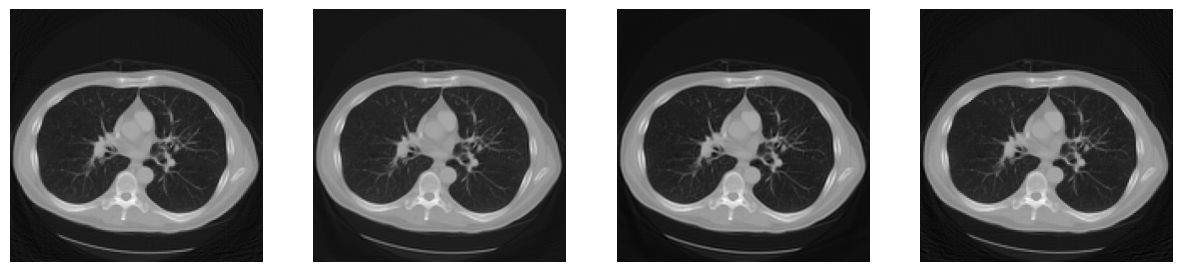

Losses :  28.62518725199676 32.69231367806722 32.99710229590087 29.49927937811688
SSIM :  0.899459291108731 0.9531324748766687 0.9606958557734216 0.9004355292725517
Oversampling :  200


INFO:/tmp/pyxu_2h2vxaua:[2025-03-10 00:13:39.743265] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_2h2vxaua:[2025-03-10 00:13:39.765308] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_2h2vxaua:[2025-03-10 00:13:39.777428] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_2h2vxaua:[2025-03-10 00:13:39.789271] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_2h2vxaua:[2025-03-10 00:13:39.801020] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_2h2vxaua:[2025-03-10 00:13:39.812929] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_2h2vxaua:[2025-03-10 00:13:39.824986] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_2h2vxaua:[2025-03-10 00:13:39.837098] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_2h2vxaua:[2025-03-10 00:13:39.849146] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_2h2vxaua:[2025-03-10 00:13:39.861089] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_2h2vxaua:[2025-03-10 00:13:39.873102] Iteration 10
	iteration: 1

(200, 200)


INFO:/tmp/pyxu_2h2vxaua:[2025-03-10 00:13:39.921728] Iteration 14
	iteration: 14
	N_iter: 15.0
INFO:/tmp/pyxu_2h2vxaua:[2025-03-10 00:13:39.933397] Iteration 15
	iteration: 15
	N_iter: 16.0
INFO:/tmp/pyxu_2h2vxaua:[2025-03-10 00:13:39.945149] Iteration 16
	iteration: 16
	N_iter: 17.0
INFO:/tmp/pyxu_2h2vxaua:[2025-03-10 00:13:39.956651] Iteration 17
	iteration: 17
	N_iter: 18.0
INFO:/tmp/pyxu_2h2vxaua:[2025-03-10 00:13:39.968676] Iteration 18
	iteration: 18
	N_iter: 19.0
INFO:/tmp/pyxu_2h2vxaua:[2025-03-10 00:13:39.980570] Iteration 19
	iteration: 19
	N_iter: 20.0
INFO:/tmp/pyxu_2h2vxaua:[2025-03-10 00:13:39.992587] Iteration 20
	iteration: 20
	N_iter: 21.0
INFO:/tmp/pyxu_2h2vxaua:[2025-03-10 00:13:40.004422] Iteration 21
	iteration: 21
	N_iter: 22.0
INFO:/tmp/pyxu_2h2vxaua:[2025-03-10 00:13:40.016502] Iteration 22
	iteration: 22
	N_iter: 23.0
INFO:/tmp/pyxu_2h2vxaua:[2025-03-10 00:13:40.028368] Iteration 23
	iteration: 23
	N_iter: 24.0
INFO:/tmp/pyxu_2h2vxaua:[2025-03-10 00:13:40.04037

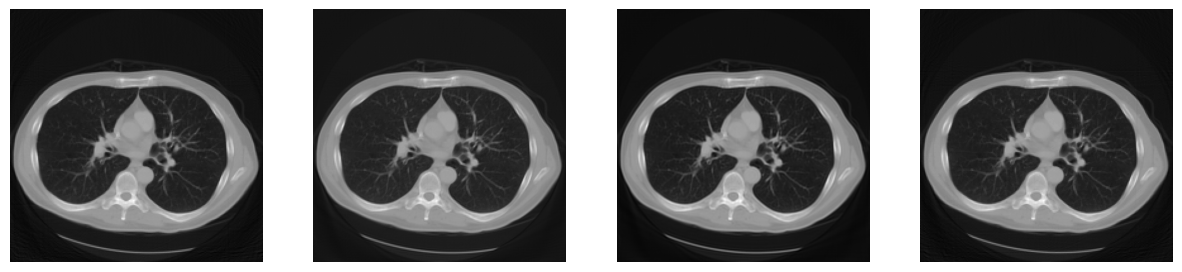

Losses :  31.205148273936395 34.69570078384581 36.25742967369382 31.934405944050166
SSIM :  0.9232946356428222 0.9638392588726 0.9708958414054808 0.9239335873145529
Oversampling :  250


INFO:/tmp/pyxu_e5nev3hd:[2025-03-10 00:14:43.554778] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_e5nev3hd:[2025-03-10 00:14:43.577297] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_e5nev3hd:[2025-03-10 00:14:43.589851] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_e5nev3hd:[2025-03-10 00:14:43.602487] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_e5nev3hd:[2025-03-10 00:14:43.614916] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_e5nev3hd:[2025-03-10 00:14:43.627714] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_e5nev3hd:[2025-03-10 00:14:43.640659] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_e5nev3hd:[2025-03-10 00:14:43.653516] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_e5nev3hd:[2025-03-10 00:14:43.666311] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_e5nev3hd:[2025-03-10 00:14:43.679046] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_e5nev3hd:[2025-03-10 00:14:43.691799] Iteration 10
	iteration: 1

(250, 250)


INFO:/tmp/pyxu_e5nev3hd:[2025-03-10 00:14:43.730057] Iteration 13
	iteration: 13
	N_iter: 14.0
INFO:/tmp/pyxu_e5nev3hd:[2025-03-10 00:14:43.742816] Iteration 14
	iteration: 14
	N_iter: 15.0
INFO:/tmp/pyxu_e5nev3hd:[2025-03-10 00:14:43.755489] Iteration 15
	iteration: 15
	N_iter: 16.0
INFO:/tmp/pyxu_e5nev3hd:[2025-03-10 00:14:43.768248] Iteration 16
	iteration: 16
	N_iter: 17.0
INFO:/tmp/pyxu_e5nev3hd:[2025-03-10 00:14:43.780724] Iteration 17
	iteration: 17
	N_iter: 18.0
INFO:/tmp/pyxu_e5nev3hd:[2025-03-10 00:14:43.793204] Iteration 18
	iteration: 18
	N_iter: 19.0
INFO:/tmp/pyxu_e5nev3hd:[2025-03-10 00:14:43.805913] Iteration 19
	iteration: 19
	N_iter: 20.0
INFO:/tmp/pyxu_e5nev3hd:[2025-03-10 00:14:43.818851] Iteration 20
	iteration: 20
	N_iter: 21.0
INFO:/tmp/pyxu_e5nev3hd:[2025-03-10 00:14:43.831696] Iteration 21
	iteration: 21
	N_iter: 22.0
INFO:/tmp/pyxu_e5nev3hd:[2025-03-10 00:14:43.844559] Iteration 22
	iteration: 22
	N_iter: 23.0
INFO:/tmp/pyxu_e5nev3hd:[2025-03-10 00:14:43.85752

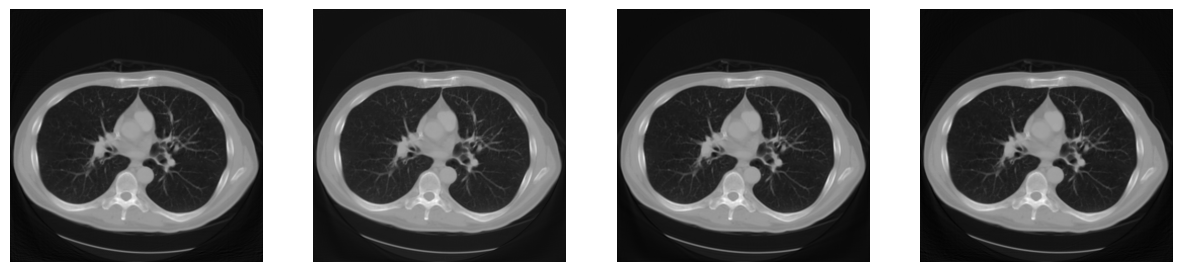

Losses :  32.895384012592345 37.654088680368645 38.38061113119715 33.55426188340364
SSIM :  0.9357593674689756 0.9678890468177802 0.9738274365314485 0.9345655067647715
Oversampling :  300


INFO:/tmp/pyxu__kdm116q:[2025-03-10 00:16:18.967188] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu__kdm116q:[2025-03-10 00:16:18.990955] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu__kdm116q:[2025-03-10 00:16:19.005171] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu__kdm116q:[2025-03-10 00:16:19.018900] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu__kdm116q:[2025-03-10 00:16:19.032611] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu__kdm116q:[2025-03-10 00:16:19.046476] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu__kdm116q:[2025-03-10 00:16:19.060588] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu__kdm116q:[2025-03-10 00:16:19.074468] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu__kdm116q:[2025-03-10 00:16:19.088503] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu__kdm116q:[2025-03-10 00:16:19.102555] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu__kdm116q:[2025-03-10 00:16:19.116632] Iteration 10
	iteration: 1

(300, 300)


INFO:/tmp/pyxu__kdm116q:[2025-03-10 00:16:19.144962] Iteration 12
	iteration: 12
	N_iter: 13.0
INFO:/tmp/pyxu__kdm116q:[2025-03-10 00:16:19.158963] Iteration 13
	iteration: 13
	N_iter: 14.0
INFO:/tmp/pyxu__kdm116q:[2025-03-10 00:16:19.172987] Iteration 14
	iteration: 14
	N_iter: 15.0
INFO:/tmp/pyxu__kdm116q:[2025-03-10 00:16:19.187452] Iteration 15
	iteration: 15
	N_iter: 16.0
INFO:/tmp/pyxu__kdm116q:[2025-03-10 00:16:19.201611] Iteration 16
	iteration: 16
	N_iter: 17.0
INFO:/tmp/pyxu__kdm116q:[2025-03-10 00:16:19.215929] Iteration 17
	iteration: 17
	N_iter: 18.0
INFO:/tmp/pyxu__kdm116q:[2025-03-10 00:16:19.230089] Iteration 18
	iteration: 18
	N_iter: 19.0
INFO:/tmp/pyxu__kdm116q:[2025-03-10 00:16:19.244092] Iteration 19
	iteration: 19
	N_iter: 20.0
INFO:/tmp/pyxu__kdm116q:[2025-03-10 00:16:19.258204] Iteration 20
	iteration: 20
	N_iter: 21.0
INFO:/tmp/pyxu__kdm116q:[2025-03-10 00:16:19.272290] Iteration 21
	iteration: 21
	N_iter: 22.0
INFO:/tmp/pyxu__kdm116q:[2025-03-10 00:16:19.28648

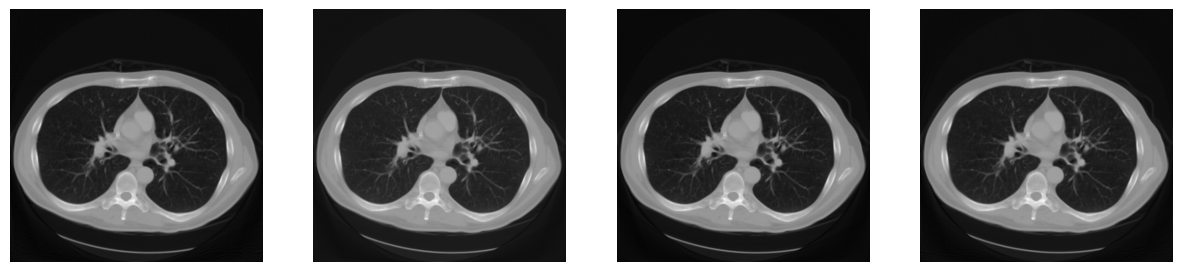

Losses :  34.339177428134015 39.157822262021256 39.96603833306813 34.85629984149839
SSIM :  0.9430731461233688 0.9697182704297651 0.9739169566879953 0.9408416869630158
Oversampling :  375


INFO:/tmp/pyxu_okdu_xq4:[2025-03-10 00:19:02.795585] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_okdu_xq4:[2025-03-10 00:19:02.821979] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_okdu_xq4:[2025-03-10 00:19:02.838539] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_okdu_xq4:[2025-03-10 00:19:02.855641] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_okdu_xq4:[2025-03-10 00:19:02.872874] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_okdu_xq4:[2025-03-10 00:19:02.890399] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_okdu_xq4:[2025-03-10 00:19:02.907939] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_okdu_xq4:[2025-03-10 00:19:02.925144] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_okdu_xq4:[2025-03-10 00:19:02.942620] Iteration 8
	iteration: 8
	N_iter: 9.0


(375, 375)


INFO:/tmp/pyxu_okdu_xq4:[2025-03-10 00:19:02.959975] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_okdu_xq4:[2025-03-10 00:19:02.977333] Iteration 10
	iteration: 10
	N_iter: 11.0
INFO:/tmp/pyxu_okdu_xq4:[2025-03-10 00:19:02.994677] Iteration 11
	iteration: 11
	N_iter: 12.0
INFO:/tmp/pyxu_okdu_xq4:[2025-03-10 00:19:03.012345] Iteration 12
	iteration: 12
	N_iter: 13.0
INFO:/tmp/pyxu_okdu_xq4:[2025-03-10 00:19:03.030169] Iteration 13
	iteration: 13
	N_iter: 14.0
INFO:/tmp/pyxu_okdu_xq4:[2025-03-10 00:19:03.047742] Iteration 14
	iteration: 14
	N_iter: 15.0
INFO:/tmp/pyxu_okdu_xq4:[2025-03-10 00:19:03.065244] Iteration 15
	iteration: 15
	N_iter: 16.0
INFO:/tmp/pyxu_okdu_xq4:[2025-03-10 00:19:03.083498] Iteration 16
	iteration: 16
	N_iter: 17.0
INFO:/tmp/pyxu_okdu_xq4:[2025-03-10 00:19:03.100850] Iteration 17
	iteration: 17
	N_iter: 18.0
INFO:/tmp/pyxu_okdu_xq4:[2025-03-10 00:19:03.118592] Iteration 18
	iteration: 18
	N_iter: 19.0
INFO:/tmp/pyxu_okdu_xq4:[2025-03-10 00:19:03.136044]

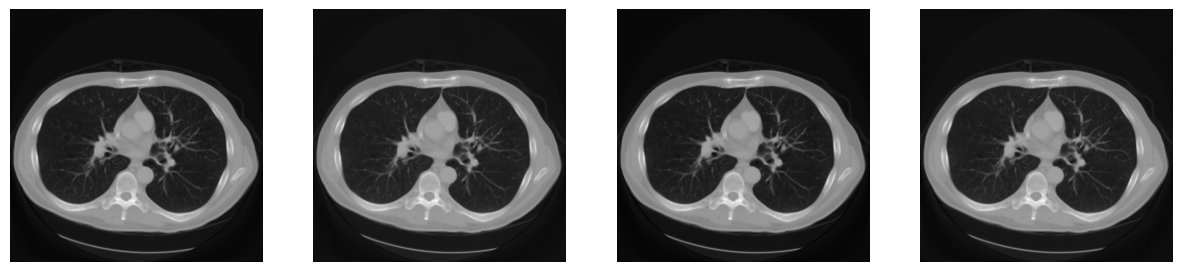

Losses :  36.0707248727585 41.08182236411038 41.55467220476466 36.45369209510171
SSIM :  0.9511347021727811 0.9717510309806722 0.9740159564687528 0.9485877416661881
Oversampling :  500


INFO:/tmp/pyxu_q9fz4828:[2025-03-10 00:24:51.438121] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_q9fz4828:[2025-03-10 00:24:51.470173] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_q9fz4828:[2025-03-10 00:24:51.494339] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_q9fz4828:[2025-03-10 00:24:51.517928] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_q9fz4828:[2025-03-10 00:24:51.541755] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_q9fz4828:[2025-03-10 00:24:51.565306] Iteration 5
	iteration: 5
	N_iter: 6.0


(500, 500)


INFO:/tmp/pyxu_q9fz4828:[2025-03-10 00:24:51.588671] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_q9fz4828:[2025-03-10 00:24:51.611296] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_q9fz4828:[2025-03-10 00:24:51.633712] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_q9fz4828:[2025-03-10 00:24:51.656066] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_q9fz4828:[2025-03-10 00:24:51.678257] Iteration 10
	iteration: 10
	N_iter: 11.0
INFO:/tmp/pyxu_q9fz4828:[2025-03-10 00:24:51.700575] Iteration 11
	iteration: 11
	N_iter: 12.0
INFO:/tmp/pyxu_q9fz4828:[2025-03-10 00:24:51.723114] Iteration 12
	iteration: 12
	N_iter: 13.0
INFO:/tmp/pyxu_q9fz4828:[2025-03-10 00:24:51.745661] Iteration 13
	iteration: 13
	N_iter: 14.0
INFO:/tmp/pyxu_q9fz4828:[2025-03-10 00:24:51.767363] Iteration 14
	iteration: 14
	N_iter: 15.0
INFO:/tmp/pyxu_q9fz4828:[2025-03-10 00:24:51.789463] Iteration 15
	iteration: 15
	N_iter: 16.0
INFO:/tmp/pyxu_q9fz4828:[2025-03-10 00:24:51.810986] Iteratio

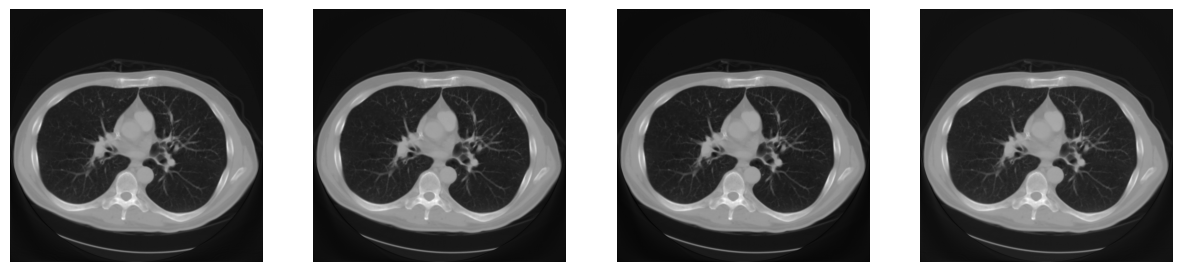

Losses :  38.24345527268491 42.62425622674754 42.790885475307306 38.33126260019253
SSIM :  0.9600962296859973 0.9722154435122545 0.9729981037656978 0.9567598299971728
Oversampling :  1000
(1000, 1000)


INFO:/tmp/pyxu_r5x8pozm:[2025-03-10 01:09:12.339779] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_r5x8pozm:[2025-03-10 01:09:12.478926] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_r5x8pozm:[2025-03-10 01:09:12.585213] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_r5x8pozm:[2025-03-10 01:09:12.689850] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_r5x8pozm:[2025-03-10 01:09:12.793859] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_r5x8pozm:[2025-03-10 01:09:12.897820] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_r5x8pozm:[2025-03-10 01:09:13.002291] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_r5x8pozm:[2025-03-10 01:09:13.105752] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_r5x8pozm:[2025-03-10 01:09:13.210055] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_r5x8pozm:[2025-03-10 01:09:13.314003] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_r5x8pozm:[2025-03-10 01:09:13.418788] Iteration 10
	iteration: 1

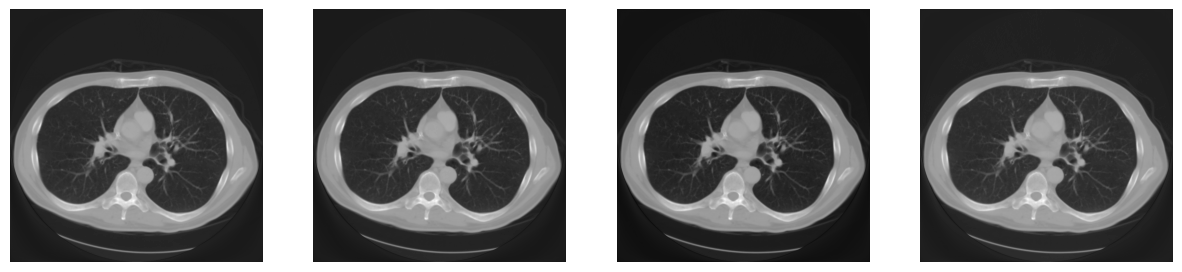

Losses :  41.768566380180616 43.165024169091254 43.774540553994854 41.054428217396804
SSIM :  0.9690933671426126 0.9707046419667396 0.9722214448859571 0.9647536472164112


In [6]:
oversamplings =[20, 40, 50, 75, 100, 120, 150, 200, 250, 300, 375, 500, 1000]
losses1 = []
losses2 = []
losses3 = []
losses4 = []

ssims1 = []
ssims2 = []
ssims3 = []
ssims4 = []

images_pix = []
images_spline1 = []
images_spline2 = []
images_astra = []

for oversampling in oversamplings:
    print('Oversampling : ', oversampling)
    loss1, loss2, loss3, loss4, full_im_pix, full_im_spline1, full_im_spline2, full_im_astra, ssim1, ssim2, ssim3, ssim4 = run_xp(2*oversampling, 2*oversampling, oversampling, phantom)
    losses1.append(loss1)
    losses2.append(loss2)
    losses3.append(loss3)
    losses4.append(loss4)
    ssims1.append(ssim1)
    ssims2.append(ssim2)
    ssims3.append(ssim3)
    ssims4.append(ssim4)


    images_pix.append(full_im_pix)
    images_spline1.append(full_im_spline1)
    images_spline2.append(full_im_spline2)
    images_astra.append(full_im_astra)
    
    print('Losses : ', loss1, loss2, loss3, loss4)
    print('SSIM : ', ssim1, ssim2, ssim3, ssim4)

In [ ]:

#save everything

np.save('oversamplings.npy', oversamplings)
np.save('losses1.npy', losses1)
np.save('losses2.npy', losses2)
np.save('losses3.npy', losses3)
np.save('losses4.npy', losses4)

np.save('ssims1.npy', ssims1)
np.save('ssims2.npy', ssims2)
np.save('ssims3.npy', ssims3)
np.save('ssims4.npy', ssims4)

'''
np.save('images_pix.npy', images_pix)
np.save('images_spline1.npy', images_spline1)
np.save('images_spline2.npy', images_spline2)
np.save('images_astra.npy', images_astra)
'''


"#save everything\nnp.save('oversamplings.npy', oversamplings)\nnp.save('losses1.npy', losses1)\nnp.save('losses2.npy', losses2)\nnp.save('losses3.npy', losses3)\nnp.save('losses4.npy', losses4)\nnp.save('ssims1.npy', ssims1)\nnp.save('ssims2.npy', ssims2)\nnp.save('ssims3.npy', ssims3)\nnp.save('ssims4.npy', ssims4)\n\nnp.save('images_pix.npy', images_pix)\nnp.save('images_spline1.npy', images_spline1)\nnp.save('images_spline2.npy', images_spline2)\nnp.save('images_astra.npy', images_astra)"

In [8]:
#load everything
oversamplings = np.load('oversamplings.npy')
losses1 = np.load('losses1.npy')
losses2 = np.load('losses2.npy')
losses3 = np.load('losses3.npy')
losses4 = np.load('losses4.npy')
ssims1 = np.load('ssims1.npy')
ssims2 = np.load('ssims2.npy')
ssims3 = np.load('ssims3.npy')
ssims4 = np.load('ssims4.npy')
images_pix = np.load('images_pix.npy')
images_spline1 = np.load('images_spline1.npy')
images_spline2 = np.load('images_spline2.npy')
images_astra = np.load('images_astra.npy')

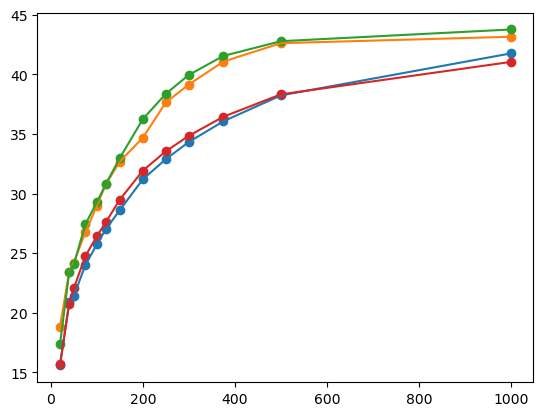

In [7]:

plt.figure('Losses')
plt.plot(oversamplings, losses1, label='Pixels psnr')
plt.plot(oversamplings, losses2, label='Box-splines 1 psnr')
plt.plot(oversamplings, losses3, label='Box-splines 2 psnr')
plt.plot(oversamplings, losses4, label='Astra psnr')

plt.scatter(oversamplings, losses1)
plt.scatter(oversamplings, losses2)
plt.scatter(oversamplings, losses3)
plt.scatter(oversamplings, losses4)
#plt.legend()
plt.show()

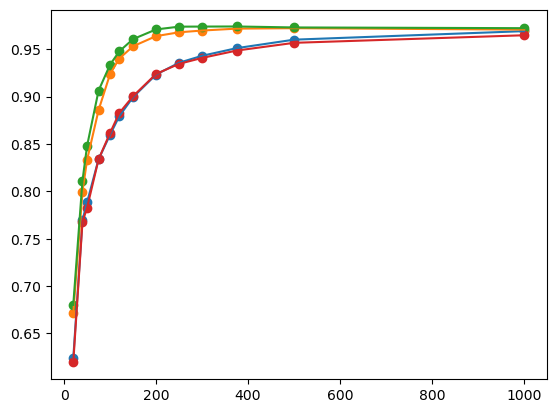

In [8]:
plt.figure('SSIM')
plt.plot(oversamplings, ssims1, label='Pixels ssim')
plt.plot(oversamplings, ssims2, label='Box-splines 1 ssim')
plt.plot(oversamplings, ssims3, label='Box-splines 2 ssim')
plt.plot(oversamplings, ssims4, label='Astra ssim')

plt.scatter(oversamplings, ssims1)
plt.scatter(oversamplings, ssims2)
plt.scatter(oversamplings, ssims3)
plt.scatter(oversamplings, ssims4)

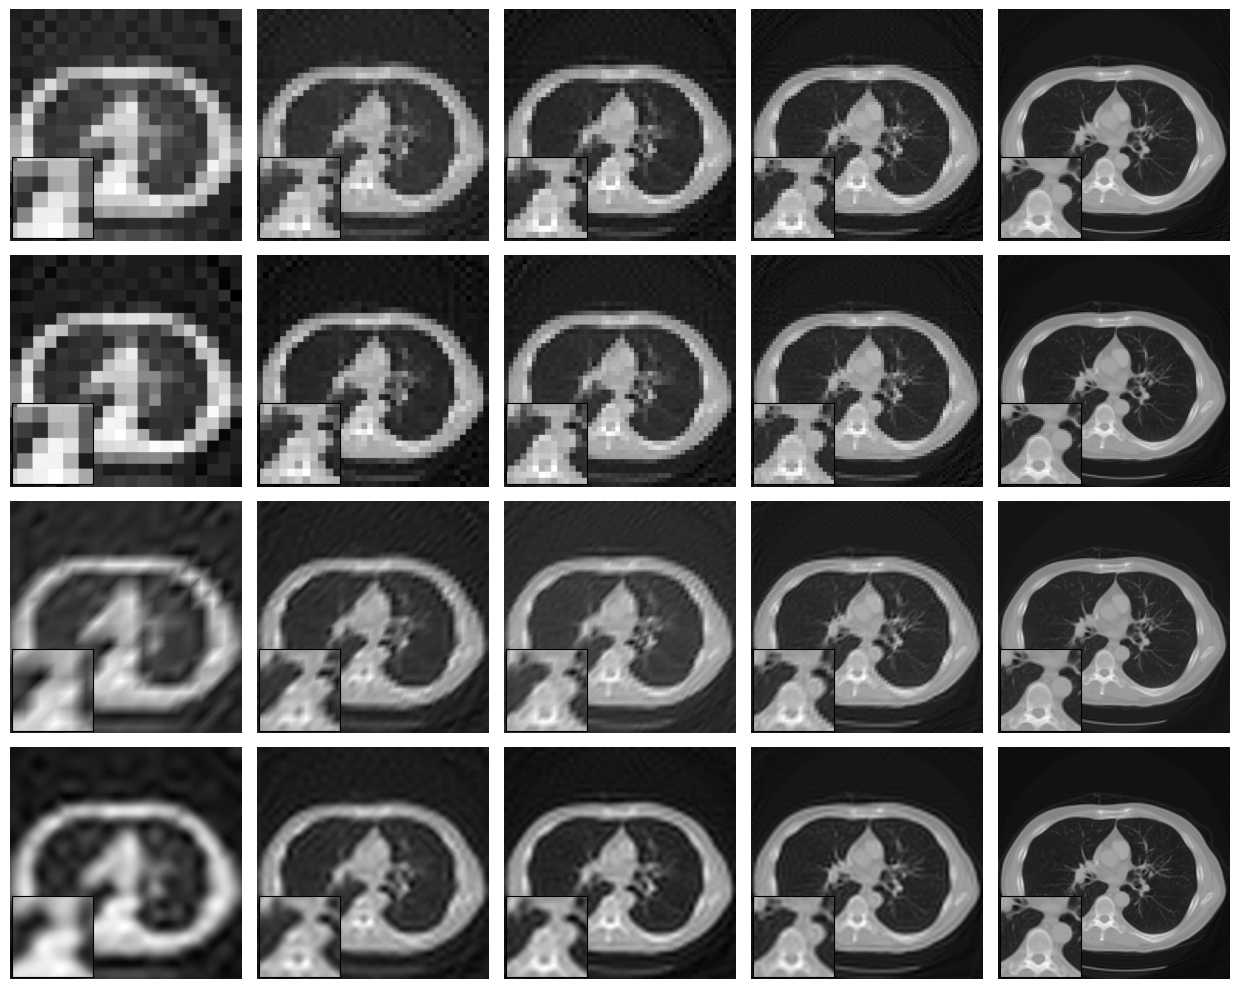

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Create figure and subplots
fig, ax = plt.subplots(4, 5, figsize=(10*5/4, 10))
k = 0

# Define the zoom-in region (adjust these values based on your images)
x1, x2, y1, y2 = 1000, 1800, 600, 1400  # Example: Region to zoom into

for i in range(len(oversamplings)):
    if i in [0, 1, 2, 3, 6]:#, 12]:  # Select specific oversampling values
        images = [images_pix[i], images_astra[i], images_spline1[i], images_spline2[i]]
        
        for row in range(4):
            # Display main image
            ax[row, k].imshow(images[row], cmap='gray')
            ax[row, k].axis('off')

            # Add inset for zoomed-in view
            axins = ax[row, k].inset_axes([0.01, 0.01, 0.35, 0.35])  # (x, y, width, height)
            #remove ticks
            axins.set_xticks([])
            axins.set_yticks([])

            # Display zoomed-in region
            axins.imshow(images[row], cmap='gray', extent=[0, images[row].shape[1], 0, images[row].shape[0]])

            # Define zoom region
            axins.set_xlim(x1, x2)
            axins.set_ylim(y1, y2)
            axins

        k += 1

        #tight layout
plt.tight_layout()
plt.savefig('table_img2.eps', format='eps')
plt.show()
